example of using strategy construction and reporting vs benchmark

In [3]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from enum import Enum
import yfinance as yf
import qis as qis
from qis import TimePeriod, MultiPortfolioData
from qis.portfolio.reports.config import fetch_default_report_kwargs
from qis.portfolio.reports.strategy_benchmark_factsheet import (generate_strategy_benchmark_factsheet_plt,
                                                                generate_strategy_benchmark_active_perf_plt,
                                                                generate_performance_attribution_report)

In [4]:
#     define custom universe with asset class grouping
def fetch_universe_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    universe_data = dict(SPY='Equities',
                         QQQ='Equities',
                         EEM='Equities',
                         TLT='Bonds',
                         IEF='Bonds',
                         LQD='Credit',
                         HYG='HighYield',
                         GLD='Gold')
    tickers = list(universe_data.keys())
    group_data = pd.Series(universe_data)  # for portfolio reporting
    prices = yf.download(tickers=tickers, start=None, end=None, ignore_tz=True)['Adj Close'][tickers]
    prices = prices.asfreq('B', method='ffill')
    benchmark_prices = prices[['SPY', 'TLT']]
    return prices, benchmark_prices, group_data

In [5]:
# define strategy and its benchmark
def generate_volparity_multiportfolio(prices: pd.DataFrame,
                                      benchmark_prices: pd.DataFrame,
                                      group_data: pd.Series,
                                      time_period: TimePeriod = None,
                                      span: int = 60,
                                      vol_target: float = 0.15,
                                      rebalancing_costs: float = 0.0010
                                      ) -> MultiPortfolioData:

    ra_returns, weights, ewm_vol = qis.compute_ra_returns(returns=qis.to_returns(prices=prices, is_log_returns=True),
                                                          span=span,
                                                          vol_target=vol_target)
    weights = weights.divide(weights.sum(1), axis=0)

    if time_period is not None:
        weights = time_period.locate(weights)

    volparity_portfolio = qis.backtest_model_portfolio(prices=prices,
                                                       weights=weights,
                                                       rebalancing_costs=rebalancing_costs,
                                                       ticker='VolParity')
    volparity_portfolio.set_group_data(group_data=group_data, group_order=list(group_data.unique()))

    ew_portfolio = qis.backtest_model_portfolio(prices=prices,
                                                weights=np.ones(len(prices.columns)) / len(prices.columns),
                                                rebalancing_costs=rebalancing_costs,
                                                ticker='EqualWeight')
    ew_portfolio.set_group_data(group_data=group_data, group_order=list(group_data.unique()))

    multi_portfolio_data = MultiPortfolioData(portfolio_datas=[volparity_portfolio, ew_portfolio],
                                              benchmark_prices=benchmark_prices)
    return multi_portfolio_data

In [6]:
# time period for portfolio reporting
time_period = qis.TimePeriod('31Dec2006', '16Oct2024')
# fetch prices
prices, benchmark_prices, group_data = fetch_universe_data()


[*********************100%%**********************]  8 of 8 completed


In [7]:
multi_portfolio_data = generate_volparity_multiportfolio(prices=prices,
                                                          benchmark_prices=benchmark_prices,
                                                          group_data=group_data,
                                                             time_period=time_period,
                                                             span=30,
                                                             vol_target=0.15,
                                                             rebalancing_costs=0.0010  # per traded volume
                                                             )

[*********************100%%**********************]  1 of 1 completed


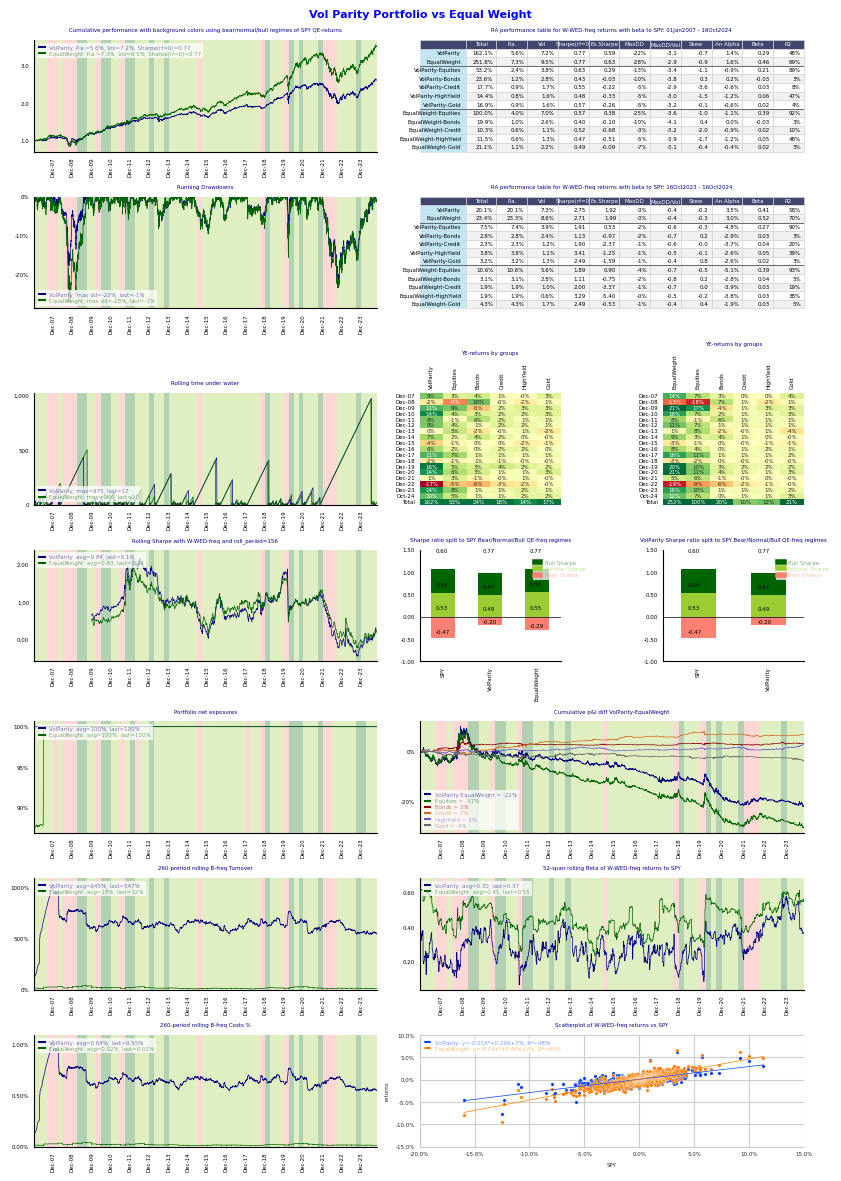

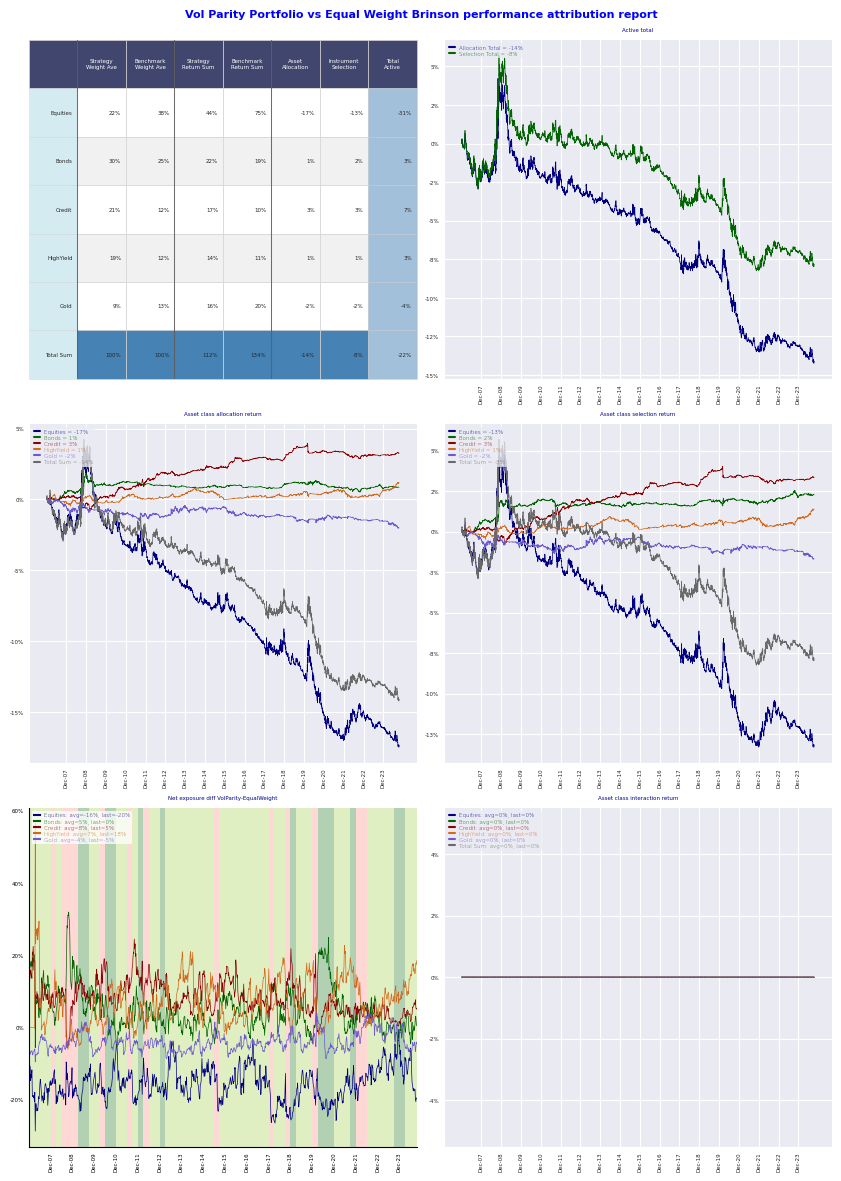

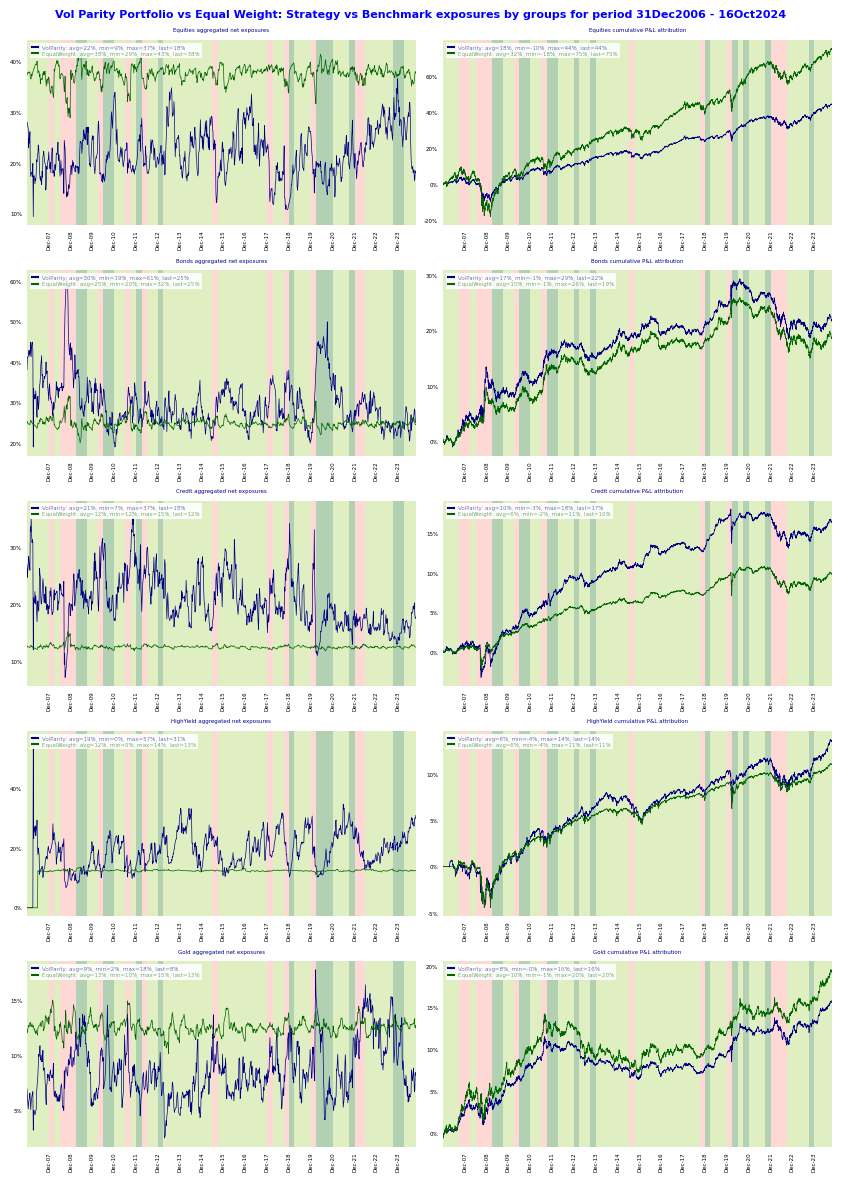

In [8]:
figs = generate_strategy_benchmark_factsheet_plt(multi_portfolio_data=multi_portfolio_data,
                                                 backtest_name='Vol Parity Portfolio vs Equal Weight',
                                                 time_period=time_period,
                                                 add_brinson_attribution=True,
                                                 add_exposures_pnl_attribution=True,
                                                 add_strategy_factsheet=False, # for strategy factsheet
                                                 add_grouped_exposures=False,  # for strategy factsheet
                                                 add_grouped_cum_pnl=False,  # for strategy factsheet
                                                 **fetch_default_report_kwargs(time_period=time_period))